In [1]:
# import libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

In [8]:
# load dataset
data = pd.read_csv("/content/diabetes.csv")
columns = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
data[columns] = data[columns].replace(0, np.NaN)
data = data.dropna()
data['Outcome'] = data['Outcome'].apply(lambda x: -1 if (x == 1) else 1)

#------------------------------------------------------------------------------     #Data dividing for tran, valid and test
ntrain = int(len(data)*0.90)
nvalid = int(len(data)*0.95)
#-----------------------------------------------------------------------------     # train, validation and test data
Xtrain = data.iloc[:ntrain, 0:8].values
Xvalid = data.iloc[ntrain:nvalid, 0:8].values
Xtest = data.iloc[nvalid:, 0:8].values

Ytrain = data.iloc[:ntrain, 8:9].values
Yvalid = data.iloc[ntrain:nvalid, 8:9].values
Ytest = data.iloc[nvalid:, 8:9].values
#-------------------------------------------------------------------------------      # standardized data
scaler_xtrain = MinMaxScaler()
xtrain_sc = scaler_xtrain.fit_transform(Xtrain)

scaler_xvalid = MinMaxScaler()
xvalid_sc = scaler_xvalid.fit_transform(Xvalid)

scaler_xtest = MinMaxScaler()
xtest_sc = scaler_xtest.fit_transform(Xtest)
#------------------------------------------------------------------------------       # Adding ones column in the data
ones_tn = np.ones(shape = (xtrain_sc.shape[0],1))
xtrain_sc = np.hstack([ones_tn, xtrain_sc])

ones_va = np.ones(shape = (xvalid_sc.shape[0],1))
xvalid_sc =  np.hstack([ones_va, xvalid_sc])

ones_ts = np.ones(shape = (xtest_sc.shape[0],1))
xtest_sc = np.hstack([ones_ts, xtest_sc])


train = np.append(Ytrain, xtrain_sc, axis = 1)


In [3]:
def intializer(layers):   # intialize paramters
  np.random.seed(3)
  W = np.random.randn(layers[0], layers[1])*0.1
  return (W)

def decision_fn(z):                   # decision fn                                         
  dec = np.where(z > 0, -1, 1)
  return(dec)

def weight_upadte(W, lr, grads, labd):
  Wnew = W + lr*grads - (lr*labd*W)        
  return (Wnew)

def predict(X, W):  #predict
  Z = np.dot(X, W)
  A = decision_fn(Z)
  return (A)
########################################## shuffling algorithm  ##########################################
def indicesShuffle(number):
  indexlist = []
  i = 0
  while (i< number):
    n = np.random.randint(0, number)
    if n in indexlist:
      i = i
    else:
      indexlist.append(n)
      i = i + 1
  return (indexlist)

def shuffler(X):
  number = X.shape[0]
  indexShuffle = indicesShuffle(number)
  shuffleArray = np.empty((X.shape))
  for stack,ix in zip(indexShuffle, range(number)):
    shuffleArray[ix] = X[stack]
  return (shuffleArray, indexShuffle)

def minimumcost(vault):
  ix = vault[4].index(min(vault[4]))                         
  W = vault[0][ix]
  return (W)


def SPLPrediction(X,Y,W):   # prediction and metric fn
  pred = predict(X, W)
  accuracy = accuracy_score(Y, pred)*100
  f1 = f1_score(Y, pred)*100
  misclassification = 100-accuracy
  result = [accuracy, f1, misclassification]
  return (result)


In [4]:
def SPLCV( XT, YT, lrT,  labdT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, XV, YV, simulationV):   # core algorithm for the model 2
  shuffdict = {}
  costs = []
  zpred = []
  Apred = []
  weights = []
  errpred = []
  results = []
  m = XT.shape[0]
  W = intializer(layersT)
  shuffle = 1
  while (shuffle < shuffleTime):   # shuffle
    xtrain, indexes = shuffler(train)
    shuffdict['shuffle '+str(shuffle)] = xtrain
    xdata = xtrain[:, 1:10]
    ydata = xtrain[:, 0:1]
    for iter in range(simulationT):
      Z = np.dot(xdata, W)
      A = decision_fn(Z)
      E = np.multiply(ydata,A)
      E =  np.maximum(0, -E)
      Loss = np.sum(E)
      cost = Loss/m + (labdT/(2*m)*np.dot(W.T, W))
      costs.append(cost)                                        #emperical risk
      grads = np.dot(xdata.T,A)
      weights.append(W)
      W = weight_upadte(W, lrT, grads, labdT)
    Tvault = [weights, zpred, Apred, errpred, costs]
    TWmin = minimumcost(Tvault)                              # get min.cost and corresponding weight
    validvault = validator(lrV, labdV, layersV, XV, YV, simulationV, TWmin)    # use the training phase parameter
    Vwmin = minimumcost(validvault)                                        # find the min. cost and correponding weight
    result = SPLPrediction(xtest_sc, Ytest, Vwmin)                           # use the validatipn phase para,eter to fit test dataset.
    results.append(result)
    shuffle = shuffle + 1                 #shuffle again
  return (results)


def validator(lr, labd, layers, X, Y, simulation, W = 0):         # algo for L2 regularization
  zpred = []
  Apred = []
  errpred = []
  costs = []
  weights = []
  m = X.shape[0]
  for iter in range(simulation):
    Z = np.dot(X, W)
    A = decision_fn(Z)
    E = np.multiply(Y,A)
    E =  np.maximum(0, -E)
    Loss = np.sum(E)
    cost = Loss/m + (labd/(2*m)*np.dot(W.T, W))
    costs.append(cost)                                       
    grads = np.dot(X.T,A)
    weights.append(W)
    W = weight_upadte(W, lr, grads, labd)
  vault = [weights, zpred, Apred, errpred, costs]
  return (vault)

Test-1

In [5]:
#use 60-85-15 data split
lrT = 0.05
labdT = 0.0001
layersT = [xtrain_sc.shape[1], 1]
shuffleTime = 20
simulationT = 10000

lrV = 0.01
labdV = 0.0001
layersV = [xvalid_sc.shape[1], 1]
simulationV = 3000
results1 = SPLCV(xtrain_sc, Ytrain, lrT,  labdT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, xvalid_sc, Yvalid, simulationV)

avg_results1 = np.asarray(results1)
accuracy1 = np.mean(avg_results1[:, 0:1])
f1_1 = np.mean(avg_results1[:, 1:2])
misclf1 = np.mean(avg_results1[:, 2:3])

Test-2

In [7]:
#use 85-95-5 data split
lrT = 0.01
labdT = 0.005
layersT = [xtrain_sc.shape[1], 1]
shuffleTime = 5
simulationT = 10000

lrV = 0.01
labdV = 0.0005
layersV = [xvalid_sc.shape[1], 1]
simulationV = 10000
results2 = SPLCV(xtrain_sc, Ytrain, lrT,  labdT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, xvalid_sc, Yvalid, simulationV)

avg_results2 = np.asarray(results2)
accuracy2 = np.mean(avg_results2[:, 0:1])
f1_2 = np.mean(avg_results2[:, 1:2])
misclf2 = np.mean(avg_results2[:, 2:3])

Test-3

In [9]:
#use 90-95-5 data split
lrT = 0.01
labdT = 0.05
layersT = [xtrain_sc.shape[1], 1]
shuffleTime = 50
simulationT = 10000

lrV = 0.01
labdV = 0.0005
layersV = [xvalid_sc.shape[1], 1]
simulationV = 10000
results3 = SPLCV(xtrain_sc, Ytrain, lrT,  labdT, layersT,shuffleTime, simulationT,lrV, labdV, layersV, xvalid_sc, Yvalid, simulationV)

avg_results3 = np.asarray(results3)
accuracy3 = np.mean(avg_results3[:, 0:1])
f1_3 = np.mean(avg_results3[:, 1:2])
misclf3 = np.mean(avg_results3[:, 2:3])

The accurcay of TEST-1 69.22390722569133
The accurcay of TEST-2 70.0
The accurcay of TEST-3 74.89795918367346
------------------------------------------------------


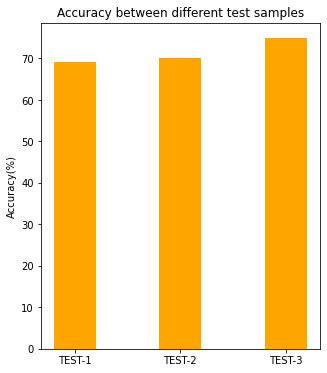

In [10]:
print("The accurcay of TEST-1", accuracy1)
print("The accurcay of TEST-2", accuracy2)
print("The accurcay of TEST-3", accuracy3)
print("------------------------------------------------------")
plt.figure(figsize = (5,6))
plt.bar(x = ['TEST-1', 'TEST-2', 'TEST-3'], height = [accuracy1, accuracy2, accuracy3], width = 0.4, color = 'orange')
plt.title("Accuracy between different test samples")
plt.ylabel("Accuracy(%)")
plt.show()

In [ ]:
misclf3

25.102040816326532